# Segmentation



### Task Set 1: Dense ResNet and Loss

* Take a ResNet18 network and add a decoder such that the network generates an output tensor having the same spatial extent as the input. Add a skip connection after conv1, layer1, layer2 and layer3.
* Add a parameter $k$ which controls the width (number of channels) of the decoder.
* The cross entropy can be used for image-to-image tasks by applying it per-pixel. Use the tensors `a_pred` and `a_gt` to compute the cross-entropy (you can use PyTorch's cross_entropy function).
* Implement the intersection over union metric (also known as Jaccard index), which computes a score for each class. 
  * Also report the meanIoU, which is a mean of classwise scores. 
  * Apply the function on the tensors `a_pred` and `a_gt`.
  * What happens if you add a batch dimension (`a_pred.unsqueeze(0)` and `a_gt.unsqueeze(0)`)?
* Pass dummy tensors (`torch.zeros()`) to the network and the loss function to show that they work.

**Literature:**
* U-Net: https://arxiv.org/abs/1505.04597
* ResNet: https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* Torchvision ResNet implementation: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py


In [1]:
import torch
from torch import nn
from torch.nn import functional as nnf
from torchvision.models import resnet18
from matplotlib import pyplot as plt
import numpy as np
from os.path import join, expanduser

data_path = expanduser('~/datasets')

a_pred = torch.zeros(3, 100, 100)
a_pred[0, 20:90, 10:90] = 1.2
a_pred[0, 15:, 20:70] += 5.3
a_pred[1, 15:100, 30:60] = 8.3
a_pred[2, 60:100, 80:] = 7.2

a_gt = torch.zeros(100, 100, dtype=torch.int64)
a_gt[20:100, 30:60] = 1
a_gt[50:80, 60:90] = 2

dummy_inp = torch.randn(1, 3, 128, 128)
dummy_labels = torch.randint(0, 5, (128, 128))  # assumes five classes

# use this cross entropy function
nnf.cross_entropy

<function torch.nn.functional.cross_entropy(input: torch.Tensor, target: torch.Tensor, weight: Union[torch.Tensor, NoneType] = None, size_average: Union[bool, NoneType] = None, ignore_index: int = -100, reduce: Union[bool, NoneType] = None, reduction: str = 'mean', label_smoothing: float = 0.0) -> torch.Tensor>

In [2]:
BlockUp(64)(torch.rand(1,64,200,200)).shape

NameError: name 'BlockUp' is not defined

In [3]:
a = torch.rand(1,512,10,10)

In [4]:
class Test(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.conv1        = nn.Conv2d(channels, channels*2, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv2        = nn.ConvTranspose2d(channels*2, channels, kernel_size= 7, stride=2, padding=3, bias=False)
    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.conv2(x)
        return x

In [5]:
Test(32)

Test(
  (conv1): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (conv2): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
)

In [6]:
Test(32)(torch.rand(1,32,128,128)).shape

torch.Size([1, 64, 64, 64])


torch.Size([1, 32, 127, 127])

In [7]:
class BlockBasic(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.conv1      = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu       = nn.ReLU(inplace = True)
        self.bn1        = nn.BatchNorm2d(channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2      = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2        = nn.BatchNorm2d(channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    def forward(self, x):
        out = nn.Sequential(self.conv1,
                          self.bn1,
                          self.relu,
                          self.conv2,
                          self.bn2,
                          self.relu)(x)
        return x + out

In [8]:
class BlockUp(nn.Module):
    def __init__(self,in_channels):
        super().__init__()
        self.conv1      = nn.ConvTranspose2d(in_channels, int(in_channels/2), kernel_size= 2, stride=2, padding=0, bias=False)
        self.relu       = nn.ReLU(inplace = True)
        channels = int(in_channels/2)
        self.bn1        = nn.BatchNorm2d(channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2      = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2        = nn.BatchNorm2d(channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.skip = nn.ConvTranspose2d(in_channels,int(in_channels/2),kernel_size = 1, stride = 2, padding=0)
    def forward(self, x):
        out= x 
        out = self.skip(out)
        out = nn.functional.interpolate(out,(x.shape[3]*2,x.shape[3]*2))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x + out

In [9]:
class End(nn.Module):
    def __init__(self,channels,out_maps):
        super().__init__()
        self.lastconv = nn.ConvTranspose2d(channels, out_maps, kernel_size= 7, stride=2, padding=3, bias=False)
        

    def forward(self, x):
        shape_x = x.shape
        
        
        x = self.lastconv(x)
        x = nn.functional.interpolate(x,(shape_x[3]*2,shape_x[3]*2))
        return x

In [10]:
End(64,10)(torch.rand(1,64,12,12)).shape

torch.Size([1, 10, 24, 24])

In [11]:
a = torch.rand(1,64,128,128)
nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=False)(torch.cat((a,a),1)).shape

torch.Size([1, 64, 128, 128])

In [12]:
BlockUp(64)(torch.rand(1,64,128,128)).shape

torch.Size([1, 32, 256, 256])

In [13]:
block = UpSample(512)

NameError: name 'UpSample' is not defined

In [14]:
nn.Sequential(rn18.conv1,rn18.bn1,rn18.relu,rn18.layer1)(torch.rand(1,3,128,128)).shape

NameError: name 'rn18' is not defined

In [15]:
nn.Sequential(rn18.conv1,rn18.bn1,rn18.relu)

NameError: name 'rn18' is not defined

In [16]:
rn18 = resnet18(pretrained=False)
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer0 = rn18.conv1
        self.layer1 = nn.Sequential(rn18.bn1,rn18.relu,rn18.layer1)
        self.layer2 = rn18.layer2
        self.layer3 = rn18.layer3
        self.layer4 = rn18.layer4
        self.layer5_1 = BlockUp(512)
        self.layer5_2 = BlockBasic(256)
        self.layer6_1 = BlockUp(256)
        self.layer6_2 = BlockBasic(128)
        self.layer7_1 = BlockUp(128)
        self.layer7_2 = BlockBasic(64)
        self.layer8_1 = BlockBasic(64)
        self.layer8_2 = BlockBasic(64)
        
        
        self.skip0 = nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=False)
        self.skip1 = nn.Conv2d(128, 64, kernel_size=1, stride=1, bias=False)
        self.skip2 = nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False)
        self.skip3 = nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False)
        
        self.bnlast   = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu  = nn.ReLU(inplace = True)
        
        self.end = End(64,22)


    def forward(self, x):
        x = self.layer0(x)
        skip0 = x
        x = self.layer1(x)
        skip1 = x 
        x = self.layer2(x)
        skip2 = x 
        x = self.layer3(x)
        skip3 = x 
        x = self.layer4(x)
        x = self.layer5_1(x)
        x = self.layer5_2(x)
        x = self.skip3(
        )
        
        x = self.layer6_1(x)
        x = self.layer6_2(x)
        x = self.skip2(torch.cat((x,skip2),1))
        
        x = self.layer7_1(x)
        x = self.layer7_2(x)
        x = self.skip1(torch.cat((x,skip1),1))
        x = self.layer8_1(x)
        x = self.layer8_2(x)
        
        x = self.skip0(torch.cat((x,skip0),1))
        x = nn.Sequential(self.relu,self.bnlast)(x)
        x = self.skip0(torch.cat((x,skip0),1))
        x = self.end(x)
        return x

UNet()(torch.zeros(1, 3, 128, 128)).shape

torch.Size([1, 22, 128, 128])

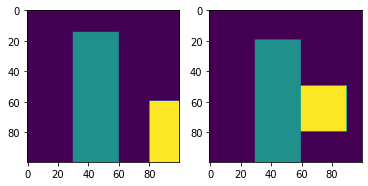

In [17]:
_, ax = plt.subplots(1, 2)
ax[0].imshow(a_pred.argmax(0))
ax[1].imshow(a_gt)

In [18]:
a_pred.shape, a_gt.shape

(torch.Size([3, 100, 100]), torch.Size([100, 100]))

In [19]:
a_pred.unsqueeze(0).shape

torch.Size([1, 3, 100, 100])

In [20]:
nn.CrossEntropyLoss()(a_pred.unsqueeze(0), a_gt.unsqueeze(0))

tensor(1.1742)

In [ ]:
#torch adaptive pooling

In [25]:

a_pred.unsqueeze(0), a_gt.unsqueeze(0)

prediction_class = np.array(a_pred.argmax(0).flatten())
ground_truth_class = np.array(a_gt.flatten())
nr_classes = len(torch.unique(a_gt))
iou = 0
for i, _ in enumerate(torch.unique(a_gt)):
    class_predicted = prediction_class == i
    class_real      = ground_truth_class == i
    
    tp = (class_predicted == True)& (class_real == True)
    tn = (class_predicted == False)& (class_real == False)
    fp = (class_predicted == True)& (class_real == False)
    fn = (class_predicted == False)& (class_real == True)
    iou_class = tp.mean() / (fn.mean() + fp.mean() + tp.mean())
    iou += iou_class
iou/nr_classes

0.6261879526585409

In [26]:
np.array(a_pred.argmax(0)).shape

(100, 100)

In [27]:
def get_iou(a_pred, a_gt):
    prediction_class = np.array(a_pred.argmax(1))
    ground_truth_class = np.array(a_gt)
    nr_classes = len(torch.unique(a_gt))
    iou = 0
    for i, _ in enumerate(torch.unique(a_gt)):
        #alle klassen für die und die klasse vorhergesagt bzw. predicted wurde
        class_predicted = prediction_class == i
        class_real      = ground_truth_class == i
        #true positive u.s.w.
        tp = (class_predicted == True)& (class_real == True)
        tn = (class_predicted == False)& (class_real == False)
        fp = (class_predicted == True)& (class_real == False)
        fn = (class_predicted == False)& (class_real == True)
        iou_class = tp.mean() / (fn.mean() + fp.mean() + tp.mean())
        iou += iou_class
    return(iou/nr_classes)
    

In [28]:
get_iou(a_pred.unsqueeze(0), a_gt.unsqueeze(0))

0.6261879526585409

In [29]:
a_pred.unsqueeze(0).shape

torch.Size([1, 3, 100, 100])

In [30]:
a_gt.unsqueeze(0).shape

torch.Size([1, 100, 100])

In [31]:
b_gt = torch.randint(0,20,(10,100,100))
b_pred = torch.rand(10,20,100,100)

In [32]:
get_iou(b_pred, b_gt)

0.026326384041616274

### Task Set 2: The COCO Dataset

The COCO dataset is originally designed for object detection but here we will use it for semantic segmentation.

* Explore the COCO Dataset (`instances_val2017.json`):
    * How many object classes exist?
    * How is the area distributed among the classes?
* Use the COCO Dataset to train your dense ResNet to segment object classes using the pixel-wise cross entropy loss (do not use `torchvision.datasets`).
  * If you use a pre-trained ResNet18, make sure your data uses the same normalization as the pre-training.
  * To speed-up training, use only the classes specified in `valid_categories`. 
  * During development, use `instances_val2017.json`. Later you can switch to the full dataset `instances_train2017.json`.
  * Generate only 2,000 samples.
* Compare the predictions of your model visually with the ground truth from COCO.
* Experiment with augmentation by randomly sampling slightly different crops (take care to crop both, image and segmentation together). Does it improve the performance?
* How important is the decoder capacity $k$?

**Hint**: It is not important to include all training samples. Some samples might be too small or too big, in these cases it is ok to ignore the sample (e.g. through an exception).

In [33]:
import os

In [34]:
os.path.data_path = expanduser('~/datasets')
import json
from itertools import groupby
from os.path import join

coco = json.load(open(join(data_path, 'COCO', 'annotations', 'instances_val2017.json')))
print('keys of each annotation', coco['annotations'][0].keys())
annotations = coco['annotations']

valid_categories = list(set([1, 2, 3, 10, 11, 17, 18, 19, 28, 36, 44, 51, 52, 62, 65,  72, 78, 84, 86]))

keys of each annotation dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])


In [35]:
coco.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [36]:
sorted?

Signature: sorted(iterable, /, *, key=None, reverse=False)
Docstring:
Return a new list containing all items from the iterable in ascending order.

A custom key function can be supplied to customize the sort order, and the
reverse flag can be set to request the result in descending order.
Type:      builtin_function_or_method


In [68]:
#image_id"23" : [annotation1,annotation2,annotation3]

In [69]:
#groupby(annotations_valid, lambda x: x['image_id'])

In [70]:
#[(a, b) for a,b in groupby(annotations_valid, lambda x: x['image_id'])]

In [71]:
#for a,b in (groupby(annotations_valid, lambda x: x['image_id'])):
#    print(a)

In [72]:

#for a,b in (groupby(annotations_valid, lambda x: x['image_id'])):
#    print(next(iter(b)))

In [73]:
# alle bilder wo die category id in der liste der kategorie der ids liegt
annotations_valid = [a for a in annotations if a['category_id'] in valid_categories]
annotations_valid = sorted(annotations_valid, key=lambda x:x['image_id'])
# alle segmentations werden zusammengebracht und auf ein Bild gespeichert
annotations_by_image = {k: [a['id'] for a in v if type(a['segmentation']) == list] for k,v in groupby(annotations_valid, lambda x: x['image_id'])}
annotations_by_image = {k: v for k, v in annotations_by_image.items() if len(v) > 0}
annotations_by_id = {a['id']: a for a in annotations_valid}

In [74]:
def render_polygons(polygons, img_size, category, first_depth_index_is_bg=False, normalize=False, target_size=None):
    from skimage.draw import polygon

    """
    Computes a tensor from polygons. Expects input to be in the this form:
    `((img_height, img_width), [(object_id, [[x1, y1, x2, y2, ...], [optional further polygon]], (object_id, [[...]])])`
    `object_id_to_index` needs to map every occurring object_id to an index and there should be gaps in object_id_to_index.
    """

    if target_size is None:
        target_size = img_size
        scale = 1
    else:
        scale = target_size[0] / img_size[0], target_size[1] / img_size[1]
        raise NotImplementedError

    tensor = np.zeros((target_size[0], target_size[1]), 'uint8')

    for p in polygons:
        x = np.array(p[0::2])
        y = np.array(p[1::2])
        rr, cc = polygon(y, x, shape=target_size)
        tensor[rr, cc] = category

    if first_depth_index_is_bg:  # if a pixel has no class it is background
        tensor[:, :, 0] = 1 - tensor[:, :, 1:].sum(2)

    if normalize:
        tensor = tensor / tensor.sum(2)[:, :, np.newaxis]

    return tensor

In [75]:
def color_label_image(labels, n_colors=None):
    """ Create a color image from a label image consisting of category ids per pixel. """
    n_colors = n_colors if n_colors is not None else max(20, labels.max() + 1)
    from skimage.color import lab2rgb

    colors = np.uint8(lab2rgb(np.dstack([
        35 + np.sin(np.arange(0, 1, 1 / n_colors) * 2 * np.pi) * 20,
        np.sin(np.arange(-1, 1, 2 / n_colors) * 1.5 * np.pi) * 50,
        np.sin(np.arange(-1, 1, 2 / n_colors) * 3 * np.pi) * 50
    ])) * 255)[0]

    # gray for index 0
    colors = np.concatenate((np.array([[190, 190, 190]], 'uint8'), colors), 0)
    return colors[labels.ravel()].reshape(labels.shape + (3,))    

In [76]:
def random_crop_slices(origin_size, target_size):
    """Gets slices of a random crop. """
    assert origin_size[0] >= target_size[0] and origin_size[1] >= target_size[1], f'actual size: {origin_size}, target size: {target_size}'

    offset_y = torch.randint(0, origin_size[0] - target_size[0] + 1, (1,)).item()  # range: 0 <= value < high
    offset_x = torch.randint(0, origin_size[1] - target_size[1] + 1, (1,)).item()

    return slice(offset_y, offset_y + target_size[0]), slice(offset_x, offset_x + target_size[1])

In [86]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

samples = []
max_samples = 100  # increase this later on
i = 0

for img_id, ann_ids in annotations_by_image.items():
    
    anns = [annotations_by_id[i] for i in ann_ids]
    filename = join(data_path, 'COCO', 'val2017', f'{img_id:012d}.jpg')
    img = Image.open(filename)

    labels = np.zeros((img.height, img.width), 'uint8')

    for ann in anns:
        c = valid_categories.index(ann['category_id'])+1
        #render polygons
        image_pos = int(np.where(image_ids == ann["image_id"])[0])
        img_size = coco['images'][image_pos]["height"], coco['images'][image_pos]["width"]
        polygons2 = ann["segmentation"]
        category = ann["category_id"]
        polygon = render_polygons(polygons2,img_size,category)

       # polygon = render_polygons(ann["segmentation"], 
    # das sollte jetzt klappen
        labels[polygon > 0] = c
    assert labels.max() > 0
    new_size = (int(img.width*0.5), int(img.height*0.5))
    
    img = img.resize(new_size)
    img = np.array(img)
    
    # scale the labels
    labels = torch.tensor(labels)
    labels = labels.unsqueeze(0)
    labels = nn.functional.interpolate(labels.unsqueeze(0),scale_factor = 0.5, mode ="nearest")
    labels = labels.squeeze()
    labels = np.array(labels)

    try:
        
        # randomly crop slices here
        #img_crop = random_crop_slices(img.shape, (128,128,3))
        label_crop = random_crop_slices(labels.shape, (128,128))
        img = img[label_crop]
        labels = labels[label_crop]
        if len(img.shape) == 2:
            img = np.dstack([img]*3)
       # assert img.shape == (180, 180, 3)
        img = img.transpose([2, 0, 1])
        samples += [(img, labels)]
        
    except AssertionError:
        pass
    
    i += 1
    if i > max_samples:
        break
        
# filter samples that are very small, i.e. where label cover less than 5% of the imag
    
class COCOSeg(object):
    
    def __init__(self, samples):
        self.samples = samples
        
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, i):
        return self.samples[i]
    
coco_seg = COCOSeg(samples)


/opt/practical_course/miniconda3/envs/course/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


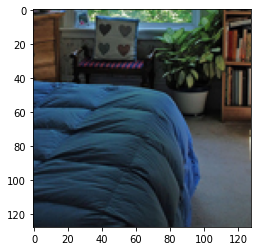

In [136]:
plt.imshow(np.transpose(samples[1][0], axes = (1,2,0)))

In [135]:
samples[1][1].shape

(128, 128)

7
4
2
2
2


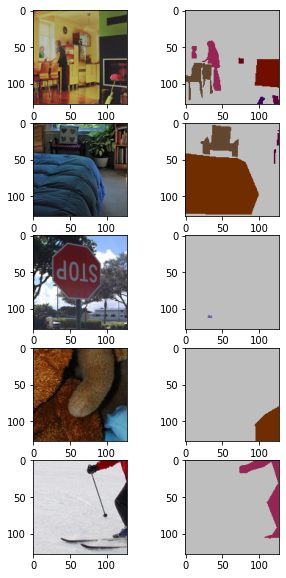

In [149]:
_, ax = plt.subplots(5, 2, figsize=(5, 10))
for j in range(5):
    print(sum(np.bincount(samples[j][1].flatten())>0))
    ax[j,0].imshow(samples[j][0].transpose([1,2,0]).astype('uint8'))
    ax[j,1].imshow(color_label_image(samples[j][1], 25))

In [96]:
rn18 = resnet18(pretrained=True)
model = UNet().cuda()

In [141]:
from torch.utils.data import DataLoader
from torch.optim import Adam

loader = DataLoader(coco_seg, batch_size=5, shuffle=True)
losses = []

opt = Adam(model.parameters(), lr=0.0001)

for i_epoch in tqdm(range(200)):
    for data_x, data_y in loader:
        
        data_x = data_x.float().cuda()
        data_y = data_y.long().cuda()
        orch.sigmoid(orch.sigmoid( = model(data_x)

        opt.zero_grad()
        
        pred = pred.permute(0,2,3,1)
        pred = pred.reshape(-1, pred.shape[3])
        data_y = data_y.reshape(-1)
        
        loss = nnf.cross_entropy(pred, data_y)
        loss.backward()
        
        opt.step()
        
        losses += [float(loss)]
        
    print(f'loss: {np.mean(losses)}')
    losses = []
        

  0%|          | 1/200 [00:00<02:31,  1.31it/s]

loss: 0.29520835503935816


  1%|          | 2/200 [00:01<02:20,  1.41it/s]

loss: 0.2893648587167263


  2%|▏         | 3/200 [00:02<02:16,  1.44it/s]

loss: 0.23006567917764187


  2%|▏         | 4/200 [00:02<02:14,  1.46it/s]

loss: 0.235949033126235


  2%|▎         | 5/200 [00:03<02:12,  1.47it/s]

loss: 0.20951162036508322


  3%|▎         | 6/200 [00:04<02:09,  1.50it/s]

loss: 0.27060848083347083


  4%|▎         | 7/200 [00:04<02:07,  1.51it/s]

loss: 0.22715498190373182


  4%|▍         | 8/200 [00:05<02:07,  1.51it/s]

loss: 0.26351166935637593


  4%|▍         | 9/200 [00:06<02:06,  1.51it/s]

loss: 0.27736149467527865


  5%|▌         | 10/200 [00:06<02:05,  1.51it/s]

loss: 0.2553942106664181


  6%|▌         | 11/200 [00:07<02:04,  1.52it/s]

loss: 0.2538509774953127


  6%|▌         | 12/200 [00:08<02:03,  1.52it/s]

loss: 0.20905800983309747


  6%|▋         | 13/200 [00:08<02:02,  1.52it/s]

loss: 0.21083707604557275


  7%|▋         | 14/200 [00:09<02:01,  1.53it/s]

loss: 0.20670794984325766


  8%|▊         | 15/200 [00:10<02:01,  1.53it/s]

loss: 0.2306364861316979


  8%|▊         | 16/200 [00:10<02:00,  1.52it/s]

loss: 0.23805510345846415


  8%|▊         | 17/200 [00:11<02:00,  1.52it/s]

loss: 0.21434731222689152


  9%|▉         | 18/200 [00:11<01:59,  1.53it/s]

loss: 0.22842287234961986


 10%|▉         | 19/200 [00:12<01:58,  1.53it/s]

loss: 0.2564361659809947


 10%|█         | 20/200 [00:13<01:57,  1.53it/s]

loss: 0.30753819551318884


 10%|█         | 21/200 [00:13<01:57,  1.52it/s]

loss: 0.3755626447498798


 11%|█         | 22/200 [00:14<01:57,  1.52it/s]

loss: 0.3267382252961397


 12%|█▏        | 23/200 [00:15<01:56,  1.52it/s]

loss: 0.25063004083931445


 12%|█▏        | 24/200 [00:15<01:55,  1.52it/s]

loss: 0.2052385943941772


 12%|█▎        | 25/200 [00:16<01:55,  1.52it/s]

loss: 0.17100048214197158


 13%|█▎        | 26/200 [00:17<01:54,  1.52it/s]

loss: 0.16376470671966672


 14%|█▎        | 27/200 [00:17<01:53,  1.52it/s]

loss: 0.1818268551491201


 14%|█▍        | 28/200 [00:18<01:52,  1.53it/s]

loss: 0.18901497200131417


 14%|█▍        | 29/200 [00:19<01:51,  1.53it/s]

loss: 0.22285468308255077


 15%|█▌        | 30/200 [00:19<01:50,  1.53it/s]

loss: 0.22885909052565695


 16%|█▌        | 31/200 [00:20<01:50,  1.53it/s]

loss: 0.1962082628160715


 16%|█▌        | 32/200 [00:21<01:49,  1.53it/s]

loss: 0.18322016038000583


 16%|█▋        | 33/200 [00:21<01:49,  1.53it/s]

loss: 0.19248056914657355


 17%|█▋        | 34/200 [00:22<01:48,  1.53it/s]

loss: 0.24594409205019474


 18%|█▊        | 35/200 [00:23<01:48,  1.52it/s]

loss: 0.18043937226757406


 18%|█▊        | 36/200 [00:23<01:47,  1.52it/s]

loss: 0.16532192574813961


 18%|█▊        | 37/200 [00:24<01:47,  1.51it/s]

loss: 0.16101275589317082


 19%|█▉        | 38/200 [00:25<01:47,  1.50it/s]

loss: 0.2175746750086546


 20%|█▉        | 39/200 [00:25<01:47,  1.49it/s]

loss: 0.17843949291855096


 20%|██        | 40/200 [00:26<01:46,  1.50it/s]

loss: 0.16596597684547304


 20%|██        | 41/200 [00:27<01:46,  1.49it/s]

loss: 0.19042495600879192


 21%|██        | 42/200 [00:27<01:45,  1.50it/s]

loss: 0.1587919073179364


 22%|██▏       | 43/200 [00:28<01:44,  1.51it/s]

loss: 0.14649065965786576


 22%|██▏       | 44/200 [00:29<01:43,  1.50it/s]

loss: 0.14254233026877045


 22%|██▎       | 45/200 [00:29<01:43,  1.50it/s]

loss: 0.15239744437858463


 23%|██▎       | 46/200 [00:30<01:42,  1.50it/s]

loss: 0.1402908969670534


 24%|██▎       | 47/200 [00:31<01:41,  1.51it/s]

loss: 0.13960905112326144


 24%|██▍       | 48/200 [00:31<01:41,  1.50it/s]

loss: 0.15617551864124835


 24%|██▍       | 49/200 [00:32<01:40,  1.50it/s]

loss: 0.1570452332496643


 25%|██▌       | 50/200 [00:33<01:40,  1.50it/s]

loss: 0.14257726175710558


 26%|██▌       | 51/200 [00:33<01:39,  1.50it/s]

loss: 0.1571564732119441


 26%|██▌       | 52/200 [00:34<01:38,  1.50it/s]

loss: 0.17041990784928202


 26%|██▋       | 53/200 [00:35<01:37,  1.50it/s]

loss: 0.24814861454069614


 27%|██▋       | 54/200 [00:35<01:37,  1.50it/s]

loss: 0.2000020133331418


 28%|██▊       | 55/200 [00:36<01:36,  1.51it/s]

loss: 0.16404161136597395


 28%|██▊       | 56/200 [00:37<01:35,  1.51it/s]

loss: 0.1544095237739384


 28%|██▊       | 57/200 [00:37<01:35,  1.51it/s]

loss: 0.1385892685968429


 29%|██▉       | 58/200 [00:38<01:34,  1.51it/s]

loss: 0.14474115329794585


 30%|██▉       | 59/200 [00:39<01:33,  1.50it/s]

loss: 0.1487541465088725


 30%|███       | 60/200 [00:39<01:33,  1.50it/s]

loss: 0.13899563681334257


 30%|███       | 61/200 [00:40<01:32,  1.51it/s]

loss: 0.14961016047745943


 31%|███       | 62/200 [00:41<01:31,  1.51it/s]

loss: 0.18711293479427696


 32%|███▏      | 63/200 [00:41<01:30,  1.51it/s]

loss: 0.19586983639746905


 32%|███▏      | 64/200 [00:42<01:30,  1.50it/s]

loss: 0.24024762250483037


 32%|███▎      | 65/200 [00:43<01:29,  1.51it/s]

loss: 0.3348265621811152


 33%|███▎      | 66/200 [00:43<01:29,  1.50it/s]

loss: 0.5311702970415354


 34%|███▎      | 67/200 [00:44<01:28,  1.50it/s]

loss: 0.5403027132153511


 34%|███▍      | 68/200 [00:45<01:27,  1.51it/s]

loss: 0.6718386586755514


 34%|███▍      | 69/200 [00:45<01:26,  1.51it/s]

loss: 0.2985479488968849


 35%|███▌      | 70/200 [00:46<01:25,  1.52it/s]

loss: 0.206254886649549


 36%|███▌      | 71/200 [00:47<01:24,  1.52it/s]

loss: 0.16723527889698744


 36%|███▌      | 72/200 [00:47<01:24,  1.52it/s]

loss: 0.1670266442000866


 36%|███▋      | 73/200 [00:48<01:23,  1.52it/s]

loss: 0.14583141570910813


 37%|███▋      | 74/200 [00:49<01:22,  1.52it/s]

loss: 0.15076235299929977


 38%|███▊      | 75/200 [00:49<01:21,  1.53it/s]

loss: 0.15018754480406643


 38%|███▊      | 76/200 [00:50<01:21,  1.53it/s]

loss: 0.13351884679868817


 38%|███▊      | 77/200 [00:50<01:20,  1.53it/s]

loss: 0.12830845797434448


 39%|███▉      | 78/200 [00:51<01:19,  1.53it/s]

loss: 0.16792280673980714


 40%|███▉      | 79/200 [00:52<01:19,  1.52it/s]

loss: 0.13582664402201772


 40%|████      | 80/200 [00:52<01:18,  1.52it/s]

loss: 0.1496861848514527


 40%|████      | 81/200 [00:53<01:18,  1.51it/s]

loss: 0.13721761722117662


 41%|████      | 82/200 [00:54<01:18,  1.51it/s]

loss: 0.1317496320232749


 42%|████▏     | 83/200 [00:54<01:17,  1.51it/s]

loss: 0.15713263172656297


 42%|████▏     | 84/200 [00:55<01:16,  1.52it/s]

loss: 0.2521396864205599


 42%|████▎     | 85/200 [00:56<01:15,  1.52it/s]

loss: 0.16202449314296247


 43%|████▎     | 86/200 [00:56<01:15,  1.51it/s]

loss: 0.14605348594486714


 44%|████▎     | 87/200 [00:57<01:14,  1.52it/s]

loss: 0.14653712608851494


 44%|████▍     | 88/200 [00:58<01:13,  1.52it/s]

loss: 0.15036524599418044


 44%|████▍     | 89/200 [00:58<01:13,  1.51it/s]

loss: 0.13820805661380292


 45%|████▌     | 90/200 [00:59<01:13,  1.50it/s]

loss: 0.11444801846519112


 46%|████▌     | 91/200 [01:00<01:12,  1.51it/s]

loss: 0.13403877010568976


 46%|████▌     | 92/200 [01:00<01:11,  1.51it/s]

loss: 0.11802340829744935


 46%|████▋     | 93/200 [01:01<01:11,  1.50it/s]

loss: 0.11829885053448379


 47%|████▋     | 94/200 [01:02<01:10,  1.50it/s]

loss: 0.11345855179242789


 48%|████▊     | 95/200 [01:02<01:09,  1.50it/s]

loss: 0.15710822786204517


 48%|████▊     | 96/200 [01:03<01:08,  1.51it/s]

loss: 0.13767244443297386


 48%|████▊     | 97/200 [01:04<01:07,  1.51it/s]

loss: 0.11895860694348812


 49%|████▉     | 98/200 [01:04<01:07,  1.52it/s]

loss: 0.12804440828040242


 50%|████▉     | 99/200 [01:05<01:06,  1.52it/s]

loss: 0.10380260441452265


 50%|█████     | 100/200 [01:06<01:05,  1.52it/s]

loss: 0.10779995443299413


 50%|█████     | 101/200 [01:06<01:05,  1.52it/s]

loss: 0.11340979058295489


 51%|█████     | 102/200 [01:07<01:04,  1.52it/s]

loss: 0.11729620741680265


 52%|█████▏    | 103/200 [01:08<01:04,  1.51it/s]

loss: 0.11677584359422326


 52%|█████▏    | 104/200 [01:08<01:03,  1.50it/s]

loss: 0.10500646508298814


 52%|█████▎    | 105/200 [01:09<01:03,  1.51it/s]

loss: 0.12555121462792157


 53%|█████▎    | 106/200 [01:10<01:02,  1.51it/s]

loss: 0.10472799562849104


 54%|█████▎    | 107/200 [01:10<01:02,  1.50it/s]

loss: 0.10708599742501974


 54%|█████▍    | 108/200 [01:11<01:01,  1.49it/s]

loss: 0.1046038287691772


 55%|█████▍    | 109/200 [01:12<01:00,  1.49it/s]

loss: 0.10832931366749107


 55%|█████▌    | 110/200 [01:12<00:59,  1.50it/s]

loss: 0.10050361072644591


 56%|█████▌    | 111/200 [01:13<00:59,  1.50it/s]

loss: 0.11456049666740001


 56%|█████▌    | 112/200 [01:14<00:58,  1.50it/s]

loss: 0.11025661556050181


 56%|█████▋    | 113/200 [01:14<00:57,  1.51it/s]

loss: 0.12270464606117457


 57%|█████▋    | 114/200 [01:15<00:56,  1.51it/s]

loss: 0.115734434267506


 57%|█████▊    | 115/200 [01:16<00:56,  1.51it/s]

loss: 0.11946840286254883


 58%|█████▊    | 116/200 [01:16<00:55,  1.51it/s]

loss: 0.11341374889016151


 58%|█████▊    | 117/200 [01:17<00:55,  1.50it/s]

loss: 0.09025613847188652


 59%|█████▉    | 118/200 [01:18<00:54,  1.50it/s]

loss: 0.09278950900770724


 60%|█████▉    | 119/200 [01:18<00:53,  1.50it/s]

loss: 0.09279008074663579


 60%|██████    | 120/200 [01:19<00:53,  1.51it/s]

loss: 0.09925076281651854


 60%|██████    | 121/200 [01:20<00:52,  1.51it/s]

loss: 0.09932382116094232


 61%|██████    | 122/200 [01:20<00:51,  1.51it/s]

loss: 0.08728645630180835


 62%|██████▏   | 123/200 [01:21<00:51,  1.51it/s]

loss: 0.09314194528851658


 62%|██████▏   | 124/200 [01:22<00:50,  1.51it/s]

loss: 0.0946389519609511


 62%|██████▎   | 125/200 [01:22<00:49,  1.51it/s]

loss: 0.09744047550484539


 63%|██████▎   | 126/200 [01:23<00:49,  1.51it/s]

loss: 0.08394676158204675


 64%|██████▎   | 127/200 [01:24<00:48,  1.51it/s]

loss: 0.1023373706266284


 64%|██████▍   | 128/200 [01:24<00:47,  1.51it/s]

loss: 0.09477384979836642


 64%|██████▍   | 129/200 [01:25<00:47,  1.50it/s]

loss: 0.08798640132881701


 65%|██████▌   | 130/200 [01:26<00:47,  1.49it/s]

loss: 0.0972644838038832


 66%|██████▌   | 131/200 [01:26<00:46,  1.49it/s]

loss: 0.12063455851748586


 66%|██████▌   | 132/200 [01:27<00:45,  1.49it/s]

loss: 0.11283534998074174


 66%|██████▋   | 133/200 [01:28<00:44,  1.50it/s]

loss: 0.10424840073101223


 67%|██████▋   | 134/200 [01:28<00:44,  1.50it/s]

loss: 0.09090939546003937


 68%|██████▊   | 135/200 [01:29<00:43,  1.50it/s]

loss: 0.0975339907221496


 68%|██████▊   | 136/200 [01:30<00:42,  1.50it/s]

loss: 0.08792441766709089


 68%|██████▊   | 137/200 [01:30<00:42,  1.49it/s]

loss: 0.08765096575953066


 69%|██████▉   | 138/200 [01:31<00:41,  1.49it/s]

loss: 0.0897284496575594


 70%|██████▉   | 139/200 [01:32<00:40,  1.50it/s]

loss: 0.07963979104533792


 70%|███████   | 140/200 [01:32<00:40,  1.50it/s]

loss: 0.08046956276521086


 70%|███████   | 141/200 [01:33<00:39,  1.50it/s]

loss: 0.07751069953665138


 71%|███████   | 142/200 [01:34<00:38,  1.50it/s]

loss: 0.08281466937623919


 72%|███████▏  | 143/200 [01:34<00:38,  1.49it/s]

loss: 0.07957473220303654


 72%|███████▏  | 144/200 [01:35<00:37,  1.49it/s]

loss: 0.07607876074034721


 72%|███████▎  | 145/200 [01:36<00:36,  1.49it/s]

loss: 0.0742474181111902


 73%|███████▎  | 146/200 [01:36<00:35,  1.50it/s]

loss: 0.07505651116371155


 74%|███████▎  | 147/200 [01:37<00:35,  1.50it/s]

loss: 0.07299022041261197


 74%|███████▍  | 148/200 [01:38<00:34,  1.49it/s]

loss: 0.06774213593453168


 74%|███████▍  | 149/200 [01:38<00:34,  1.49it/s]

loss: 0.11035847077146173


 75%|███████▌  | 150/200 [01:39<00:33,  1.48it/s]

loss: 0.138233838789165


 76%|███████▌  | 151/200 [01:40<00:32,  1.49it/s]

loss: 0.1295087343081832


 76%|███████▌  | 152/200 [01:40<00:32,  1.49it/s]

loss: 0.13553449427708983


 76%|███████▋  | 153/200 [01:41<00:31,  1.49it/s]

loss: 0.24539513606578112


 77%|███████▋  | 154/200 [01:42<00:30,  1.49it/s]

loss: 0.14503904031589626


 78%|███████▊  | 155/200 [01:42<00:30,  1.49it/s]

loss: 0.14008330311626196


 78%|███████▊  | 156/200 [01:43<00:29,  1.50it/s]

loss: 0.10827119923196733


 78%|███████▊  | 157/200 [01:44<00:28,  1.50it/s]

loss: 0.10218746969476342


 79%|███████▉  | 158/200 [01:44<00:28,  1.50it/s]

loss: 0.14848081567324697


 80%|███████▉  | 159/200 [01:45<00:27,  1.50it/s]

loss: 0.170073582790792


 80%|████████  | 160/200 [01:46<00:26,  1.50it/s]

loss: 0.21309115299955012


 80%|████████  | 161/200 [01:46<00:25,  1.51it/s]

loss: 0.1721534083597362


 81%|████████  | 162/200 [01:47<00:25,  1.51it/s]

loss: 0.23060855520889162


 82%|████████▏ | 163/200 [01:48<00:24,  1.51it/s]

loss: 0.16438950281590223


 82%|████████▏ | 164/200 [01:48<00:23,  1.51it/s]

loss: 0.16033518686890602


 82%|████████▎ | 165/200 [01:49<00:23,  1.51it/s]

loss: 0.1285038490779698


 83%|████████▎ | 166/200 [01:50<00:22,  1.51it/s]

loss: 0.09055095256771892


 84%|████████▎ | 167/200 [01:50<00:21,  1.51it/s]

loss: 0.089667606074363


 84%|████████▍ | 168/200 [01:51<00:21,  1.50it/s]

loss: 0.0930786730721593


 84%|████████▍ | 169/200 [01:52<00:20,  1.50it/s]

loss: 0.09816246358677745


 85%|████████▌ | 170/200 [01:52<00:19,  1.51it/s]

loss: 0.11382926264777779


 86%|████████▌ | 171/200 [01:53<00:19,  1.51it/s]

loss: 0.08684618910774589


 86%|████████▌ | 172/200 [01:54<00:18,  1.50it/s]

loss: 0.0784091021399945


 86%|████████▋ | 173/200 [01:54<00:17,  1.51it/s]

loss: 0.11425644690170884


 87%|████████▋ | 174/200 [01:55<00:17,  1.51it/s]

loss: 0.11596449362114072


 88%|████████▊ | 175/200 [01:56<00:16,  1.51it/s]

loss: 0.11379348719492555


 88%|████████▊ | 176/200 [01:56<00:15,  1.51it/s]

loss: 0.09490075893700123


 88%|████████▊ | 177/200 [01:57<00:15,  1.51it/s]

loss: 0.0825999891385436


 89%|████████▉ | 178/200 [01:58<00:14,  1.50it/s]

loss: 0.07516838468145579


 90%|████████▉ | 179/200 [01:58<00:13,  1.50it/s]

loss: 0.07110590618103743


 90%|█████████ | 180/200 [01:59<00:13,  1.50it/s]

loss: 0.06291971076279879


 90%|█████████ | 181/200 [02:00<00:12,  1.50it/s]

loss: 0.06423719634767622


 91%|█████████ | 182/200 [02:00<00:12,  1.50it/s]

loss: 0.07499333224259316


 92%|█████████▏| 183/200 [02:01<00:11,  1.50it/s]

loss: 0.07802974819205702


 92%|█████████▏| 184/200 [02:02<00:10,  1.49it/s]

loss: 0.06347352147568017


 92%|█████████▎| 185/200 [02:02<00:10,  1.49it/s]

loss: 0.0650733163813129


 93%|█████████▎| 186/200 [02:03<00:09,  1.49it/s]

loss: 0.0632780340500176


 94%|█████████▎| 187/200 [02:04<00:08,  1.49it/s]

loss: 0.060220088623464105


 94%|█████████▍| 188/200 [02:04<00:08,  1.48it/s]

loss: 0.06396771995350718


 94%|█████████▍| 189/200 [02:05<00:07,  1.48it/s]

loss: 0.059006142616271975


 95%|█████████▌| 190/200 [02:06<00:06,  1.48it/s]

loss: 0.058335549151524904


 96%|█████████▌| 191/200 [02:06<00:06,  1.48it/s]

loss: 0.05728112775832415


 96%|█████████▌| 192/200 [02:07<00:05,  1.48it/s]

loss: 0.057697608857415615


 96%|█████████▋| 193/200 [02:08<00:04,  1.48it/s]

loss: 0.05600829534232617


 97%|█████████▋| 194/200 [02:08<00:04,  1.49it/s]

loss: 0.059900205885060134


 98%|█████████▊| 195/200 [02:09<00:03,  1.50it/s]

loss: 0.05751131672877818


 98%|█████████▊| 196/200 [02:10<00:02,  1.50it/s]

loss: 0.05594301223754883


 98%|█████████▊| 197/200 [02:10<00:01,  1.50it/s]

loss: 0.05291784652508795


 99%|█████████▉| 198/200 [02:11<00:01,  1.50it/s]

loss: 0.052073287032544616


100%|█████████▉| 199/200 [02:12<00:00,  1.51it/s]

loss: 0.049872785503976044


100%|██████████| 200/200 [02:12<00:00,  1.51it/s]

loss: 0.05386701757088304


7
4
2
2
2


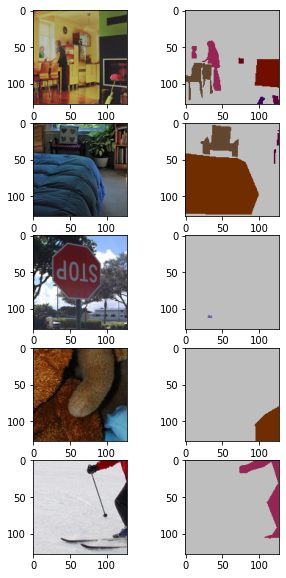

In [150]:
label = model(data_x).argmax(1)

_, ax = plt.subplots(5, 2, figsize=(5, 10))
for j in range(5):
    print(sum(np.bincount(samples[j][1].flatten())>0))
    ax[j,0].imshow(samples[j][0].transpose([1,2,0]).astype('uint8'))
    ax[j,1].imshow(color_label_image(samples[j][1], 25))


In [752]:
data_y.shape

torch.Size([81920])

In [100]:
plt.imshow(data_y.view(data_x.size(0), 180, 180)[0].cpu())

RuntimeError: shape '[4, 180, 180]' is invalid for input of size 65536

In [101]:
plt.imshow(pred.view(data_x.size(0), 180, 180, 22)[0].argmax(2).cpu())

RuntimeError: shape '[4, 180, 180, 22]' is invalid for input of size 1441792

# Keypoint Detection

The goal of keypoint detection is to localize known keypoints such as left hand or right ellbow in an unknown image. It can be used as a pre-processing step for pose-estimation.

### Task Set 3: Keypoints

* Load the keypoint data for COCO: `person_keypoints_train2017.json`
* Visualize the keypoints by overlaying them on some images.
* Prepare a dataset of images and corresponding keypoint maps of size 224x224, use only 5,000 samples.
* Train a dense ResNet on the keypoint maps using the cross-entropy loss

### Optional Tasks
* Extend the keypoint detector to a pose estimator

In [ ]:
def random_crop_special(area, image_size, size, adapt_size=False):
    
    off_x, off_y, width, height = area
    must_contain = torch.zeros(image_size).bool()
    must_contain[off_y: off_y + height, off_x: off_x + width] = 1
    return random_crop_special_by_map(must_contain, size, adapt_size)
    

def random_crop_special_by_map(must_contain, size, adapt_size=False, min_overlap=1.0, area=None):
    """ Generates crops such that the area in must_contain is always contained """

    if type(size) == int:
        size = size, size

    must_contain = must_contain.byte()
    
    if area is not None:
        off_x, off_y, width, height = area
        minx, miny = off_x, off_y
        maxx, maxy = off_x + width, off_y + height    
    else:
        proj_x = must_contain.byte().max(0).values
        proj_y = must_contain.byte().max(1).values
        minx, miny = proj_x.argmax(), proj_y.argmax()
        maxx, maxy = len(proj_x) - torch.flip(proj_x, [0]).argmax(), len(proj_y) - torch.flip(proj_y, [0]).argmax()
        width, height = maxx - minx, maxy - miny
    
    # print(minx, maxx, miny, maxy, (height, width))
    assert not adapt_size or min_overlap == 1.0
    
    # size cannot fit in
    if maxy - miny > size[0] or maxx - minx > size[1]:
        if adapt_size:
            size = max(maxy - miny, size[0]), max(maxx - minx, size[1])
        else:
            raise ValueError('fail')

    target_sum = height * width
    
    iters = 0
    while True:
        iters += 1

        lower_y = max(0, maxy - size[0])
        lower_x = max(0, maxx - size[1])
        
        upper_y = min(miny + 1, must_contain.shape[0] - size[0] + 1)
        upper_x = min(minx + 1, must_contain.shape[1] - size[1] + 1)

        off_y = torch.randint(lower_y, upper_y, (1,)).item()
        off_x = torch.randint(lower_x, upper_x, (1,)).item()
        
        if must_contain[off_y:off_y + size[0], off_x: off_x + size[1]].sum() == target_sum:
            return off_y, off_x, size
        
must_contain = torch.zeros(100,100)
must_contain[10:50, 10:50] = 1

random_crop_special_by_map(must_contain, (70, 70))

In [ ]:
import json
import numpy as np
from os.path import join
from matplotlib import pyplot as plt
# import cv2
from PIL import Image

coco_kp = json.load(open(join(data_path, 'COCO', 'annotations', 'person_keypoints_train2017.json')))
coco_kp['annotations'][0].keys()
images_by_id = {img['id']: img for img in coco_kp['images']}

# visualize these
annotations_to_visualize = [coco_kp['annotations'][i] for i in range(8)]

In [ ]:
anns = coco_kp['annotations']
anns = [a for a in anns if len([v for v in a['keypoints'][2::3] if v==2]) > 10]

# filter by extent (x and y)
anns = [a for a in anns if max(a['keypoints'][0::3]) -min(a['keypoints'][0::3]) < 300]
anns = [a for a in anns if max(a['keypoints'][1::3]) -min(a['keypoints'][1::3]) < 300]

images = list(set([a['image_id'] for a in anns]))
anns = sorted(anns, key=lambda x:x['image_id'])
anns_by_image = {k: [a['id'] for a in v] for k,v in groupby(anns, lambda x: x['image_id'])}
anns_by_id = {a['id']: a for a in anns}

print(len(anns_by_image))

### Over Night

* Prepare full datasets for segmentation and keypoint detection and train a dense ResNet18 (ImageNet pre-trained) on them.
* Evaluate the influence of different values for the decoder capacity $k$ and augmentation.
* [optional] Right now you only generate heatmaps for keypoint locations. Use these map to extract the full body pose.

In [ ]:
a = torch.from_numpy(coco_kp[0][0]).unsqueeze(0).float().cuda()

In [ ]:
pred = model(a)

In [ ]:
plt.imshow(pred[0][0].argmax(0).detach().cpu())